In [104]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [113]:
# Importing the data
from torchvision import datasets, transforms

In [114]:
# Separately loading the training and test data using the MNIST dataset from torchvision. The data will be downloaded to the 'data' folder if it is not already there. We also apply a transformation to convert the images to tensors and normalize the pixel values to be between 0 and 1 (instead of 0-255).
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
x_train = train_data.data.float() / 255.0
y_train = train_data.targets.long()
x_test = test_data.data.float() / 255.0
y_test = test_data.targets.long()

In [115]:
x_train[0] #Single Image (28x28 pixel values, each value between 0-255)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [116]:
y_train #Output data: Label of the image (0-9)

tensor([5, 0, 4,  ..., 5, 6, 8])

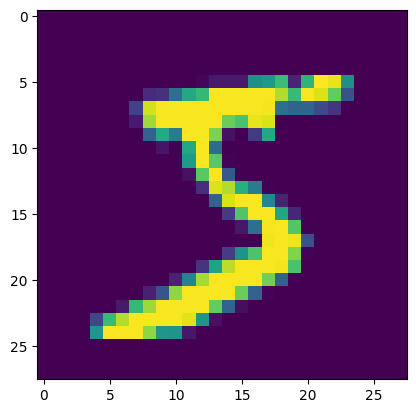

In [117]:
plt.imshow(x_train[0]) #Plotting the first image in the training data

In [118]:
# Building the model
# Using a sequential model because the layers are connected one after the other.
model = torch.nn.Sequential()

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()

        # Adding a flatten layer to convert the 2D data from the input images into a 1D array (so we can use it in a dense layer because dense layers only take 1D input). The input shape is (28, 28) because the images are 28x28 pixels.
        self.flatten = nn.Flatten()

        # Adding a dense layer to combine the features extracted by the previous layers and learn complex patterns. This layer has 128 neurons and uses ReLU activation.
        self.fc1 = nn.Linear(28 * 28, 128)
        # Adding a dropout layer to randomly set 20% of the inputs to 0 during training, which helps to prevent overfitting by making the model less reliant on specific neurons.
        self.dropout1 = nn.Dropout(0.2)

        # Same as above but with 64 neurons instead of 128 to reduce the complexity of the model and make it less likely to overfit.
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.2)

        # Adding a dense output layer with 10 neurons (one for each number) and softmax activation to get probabilities for which number the image is of. We use the dense layer here because we want to combine all the features learned by the previous layers to make a final prediction. The softmax activation is used because we want the output to be a probability distribution over the 10 classes (Numbers 0-9).
        self.fc3 = nn.Linear(64, 10)

    # The forward method defines how the input data flows through the layers of the model. We apply the flatten layer to convert the input images into a 1D array, then pass it through the first dense layer and apply ReLU activation, followed by dropout. We repeat this process for the second dense layer, and finally pass it through the output layer and apply softmax activation to get the final probabilities for each class.
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [120]:
# Instantiate model
torch.manual_seed(42)
model = MNISTModel()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Creating data loaders for training and testing data. Data loaders are used to load the data in batches during training, which helps to speed up the training process and allows us to use larger datasets that may not fit into memory all at once. We set shuffle=True for the training data to ensure that the model sees the data in a different order each epoch, which can help to improve generalization.
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader: # Loop through the training data in batches
        optimizer.zero_grad() # Clear the gradients from the previous step to prevent accumulation
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # Compute the gradients of the loss with respect to the model's parameters
        optimizer.step() # Update the model's parameters using the computed gradients

        running_loss += loss.item() # Accumulate the loss for this epoch to compute the average loss later
        _, predicted = torch.max(outputs, 1) # Get the predicted class by finding the index of the maximum output value for each sample in the batch
        total += labels.size(0) # Update the total number of samples seen so far (the batch size)
        correct += (predicted == labels).sum().item() # Update the count of correct predictions by comparing the predicted classes to the true labels and summing the number of matches

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/5, Loss: 1.6038, Accuracy: 87.13%
Epoch 2/5, Loss: 1.5298, Accuracy: 93.52%
Epoch 3/5, Loss: 1.5165, Accuracy: 94.66%
Epoch 4/5, Loss: 1.5087, Accuracy: 95.36%
Epoch 5/5, Loss: 1.5045, Accuracy: 95.78%


In [122]:
# After training the model, we can evaluate its performance on the test set to see how well it generalizes to unseen data. We disable gradients during evaluation since we are not updating the model's parameters, which can speed up the evaluation process and reduce memory usage.
model.eval()
with torch.no_grad():  # disable gradients for evaluation
    predicted = model(x_test)          # pass in test images
    test_loss = criterion(predicted, y_test)  # compute loss
    _, predicted_classes = torch.max(predicted, 1)  # get class predictions
    test_accuracy = (predicted_classes == y_test).float().mean() * 100  # accuracy in percent

print(f'Test Loss: {test_loss.item():.4f}')
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 1.4958
Test Accuracy: 96.61%
